In [1]:
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()

In [2]:
from langchain_tavily import TavilySearch

import os
import getpass

# def _set_env(var: str):
#     if not os.environ.get(var):
#         os.environ[var] = getpass.getpass(f"{var}: ")

# _set_env("TAVILY_API_KEY")

tool = TavilySearch(max_results=2)
tools = [tool]
# tool.invoke("What is the weather in Columbia MO now?")

In [3]:
import os
from langchain.chat_models import init_chat_model
import ollama
ollama.pull('qwen3:14b')

llm = init_chat_model("ollama:qwen3:14b")

In [4]:
from typing import Annotated

from langchain_tavily import TavilySearch
from langchain_core.messages import BaseMessage
from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition

class State(TypedDict):
    messages: Annotated[list, add_messages]

graph_builder = StateGraph(State)

tool = TavilySearch(max_results=2)
tools = [tool]
llm_with_tools = llm.bind_tools(tools)

def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

graph_builder.add_node("chatbot", chatbot)

tool_node = ToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
# Any time a tool is called, we return to the chatbot to decide the next step
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")
graph = graph_builder.compile(checkpointer=memory)

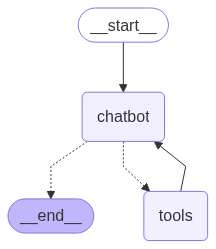

In [5]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [6]:
config = {"configurable": {"thread_id": "1"}}


In [7]:
user_input = "Hi there! My name is Will."

# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream(
    {"messages": [{"role": "user", "content": user_input}]},
    config,
    stream_mode="values",
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Hi there! My name is Will.
================================== Ai Message ==================================

<think>
Okay, the user said "Hi there! My name is Will." So first, I need to respond appropriately. Since Will introduced himself, a simple and friendly response would be best. Maybe something like "Hello, Will! Nice to meet you. How can I assist you today?" That's polite and opens the door for him to ask questions. I don't need to use any tools here because there's no query that requires searching or other functions. Just a straightforward greeting and offer of help.
</think>

Hello, Will! Nice to meet you. How can I assist you today?


In [10]:
user_input = "Remember my name?"

# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream(
    {"messages": [{"role": "user", "content": user_input}]},
    config,
    stream_mode="values",
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Remember my name?
================================== Ai Message ==================================

<think>
Okay, the user asked, "Remember my name?" Let me think about how to respond.

First, I need to check if there's any previous conversation where the user mentioned their name. Looking back, the user introduced themselves as Will in the first message. So, the assistant should acknowledge that.

But wait, in the history, the user's first message was "Hi there! My name is Will." The assistant replied with "Hi Will! Nice to meet you. How can I assist you today?" Then the user asked "Remember my name?" which is the current query.

So, the user is testing if the assistant remembers their name from the previous conversation. Since the assistant already used "Will" in the previous response, it's clear that the name was remembered. However, the user might be expecting a confirmation.

The assistant needs to c

In [11]:
# The only difference is we change the `thread_id` here to "2" instead of "1"
events = graph.stream(
    {"messages": [{"role": "user", "content": user_input}]},
    {"configurable": {"thread_id": "1"}},
    stream_mode="values",
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Remember my name?
================================== Ai Message ==================================

Yes, I remember your name is Will. Is there anything specific you want to search for?


In [7]:
user_input = "What time is it in Columbia Missouri and what is the weather in Columbia Missouri?"

# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream(
    {"messages": [{"role": "user", "content": user_input}]},
    config,
    stream_mode="values",
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

What time is it in Columbia Missouri and what is the weather in Columbia Missouri?
================================== Ai Message ==================================

<think>
Okay, the user is asking for the current time and weather in Columbia, Missouri. Let me break this down.

First, the time. Since Columbia is in the Central Time Zone, I can check the current time there. But wait, do I need to confirm if there's any daylight saving time changes? Maybe, but the user just wants the current time, so I can use a search tool to get the exact time right now.

Next, the weather. The user wants to know the current weather conditions in Columbia. I'll need to use a weather service or search tool to find the latest weather data. The tool can provide temperature, precipitation, wind speed, etc.

I should use the tavily_search function for both parts. For the time, I can search "current time in Columbia Missouri" a

In [9]:
from typing import Annotated

from langchain_tavily import TavilySearch
from langchain_core.tools import tool
from typing_extensions import TypedDict

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition

from langgraph.types import Command, interrupt

class State(TypedDict):
    messages: Annotated[list, add_messages]

graph_builder = StateGraph(State)

@tool
def human_assistance(query: str) -> str:
    """Request assistance from a human."""
    human_response = interrupt({"query": query})
    return human_response["data"]

tool = TavilySearch(max_results=2)
tools = [tool, human_assistance]
llm_with_tools = llm.bind_tools(tools)

def chatbot(state: State):
    message = llm_with_tools.invoke(state["messages"])
    # Because we will be interrupting during tool execution,
    # we disable parallel tool calling to avoid repeating any
    # tool invocations when we resume.
    assert len(message.tool_calls) <= 1
    return {"messages": [message]}

graph_builder.add_node("chatbot", chatbot)

tool_node = ToolNode(tools=tools)
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")

In [10]:
memory = MemorySaver()

graph = graph_builder.compile(checkpointer=memory)

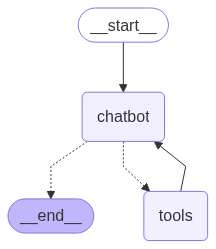

In [11]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [12]:
user_input = "I need some expert guidance for building an AI agent. Could you request assistance for me?"
config = {"configurable": {"thread_id": "1"}}

events = graph.stream(
    {"messages": [{"role": "user", "content": user_input}]},
    config,
    stream_mode="values",
)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

I need some expert guidance for building an AI agent. Could you request assistance for me?
================================== Ai Message ==================================

<think>
Okay, the user is asking for expert guidance on building an AI agent and wants me to request assistance. Let me see. The available tools are tavily_search and human_assistance. The user's query is about building an AI agent, which is a technical topic. The human_assistance function is meant for requesting help from a human, so maybe that's the right choice here. But wait, the user said "Could you request assistance for me?" So they want me to ask for help, not the other way around. The human_assistance function's parameters require a query. The user's query is about building an AI agent, so the arguments should include that. Let me check the parameters again. The function requires a "query" parameter, which is a string. So I sh